# Dynamic Guided Forecasting Experiment
Dieses Notebook enthält den Code zu den Forcasting Experimenten.


## Imports

In [12]:
#Imports
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')
# Install required libraries
!pip install ema-pytorch==0.2.1;pandas==1.5.0;scikit-learn==1.1.2;scipy==1.8.1;seaborn==0.12.2;tqdm==4.64.1;dm-control==1.0.12;dm-env==1.6;dm-tree==0.1.8;mujoco==2.3.4;gluonts==0.12.6;pyyaml==6.0
import os
import torch
import numpy as np
import sys

# Add the project directory to the system path
sys.path.insert(0,'/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS')
# Import custom modules
from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

from Utils.metric_utils import display_scores
from Utils.discriminative_metric import discriminative_score_metrics
from Utils.predictive_metric import predictive_score_metrics

import itertools
import yaml
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from Utils.cross_correlation import CrossCorrelLoss
# Install gluonts (again, just to be sure)
!pip install gluonts

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Import additional libraries for data processing and model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: scikit-learn==1.1.2: command not found
/bin/bash: line 1: dm-control==1.0.12: command not found
/bin/bash: line 1: dm-env==1.6: command not found
/bin/bash: line 1: dm-tree==0.1.8: command not found


## Data Pre Processing

In [7]:
#Daten Importieren
# Load the data from a .npy file
data = np.load('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/grid_search/macro_germany_quart/batch_size32_n_heads4_d_model64_timestamp1000/samples/macro_ground_truth_8_train.npy')
data = np.array(data)

In [8]:
np.shape(data)

(98, 8, 7)

In [9]:
# Split data into training and testing sets
train = data[0:97].reshape(-1, data.shape[-1])
test = data[97:]
# Initialize MinMaxScaler and scale the training data
scaler = MinMaxScaler()
train_scaled = normalize_to_neg_one_to_one(scaler.fit_transform(train))
# Scale the test data and reshape
test_scaled = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)
# Normalize the scaled test data
test_scaled = normalize_to_neg_one_to_one(test_scaled)

In [10]:
# Define a custom Dataset class for the macro data
class MacroDataset(Dataset):
    def __init__(self, data, regular=True, pred_length=4):
        super(MacroDataset, self).__init__()
        # Number of samples
        self.sample_num = data.shape[0]
        # Data samples
        self.samples = data
        # Flag for regular dataset (without mask)
        self.regular = regular
        # Create a mask for the prediction period
        self.mask = np.ones_like(data)
        #self.mask[:, -pred_length:, :] = 0.
        self.mask[:, -4:, :] = 0.   ####Hier 3 oder 4!!!!!!??????
        self.mask[:, -4, 0] = 1.  ######
        self.mask = self.mask.astype(bool)

    def __getitem__(self, ind):
        # Get a sample
        x = self.samples[ind, :, :]
        # Return data without mask if regular
        if self.regular:
            return torch.from_numpy(x).float()
        # Get the corresponding mask
        mask = self.mask[ind, :, :]
        # Return data and mask
        return torch.from_numpy(x).float(), torch.from_numpy(mask)

    def __len__(self):
        # Return the number of samples
        return self.sample_num

In [11]:
# Create a MacroDataset for the training data
train_dataset = MacroDataset(train_scaled.reshape(97, -1, data.shape[-1]))
# Create a DataLoader for the training dataset
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True, pin_memory=True, sampler=None)

In [13]:
# Define a class for arguments
class Args_Example:
    def __init__(self) -> None:
        # Path to the configuration file
        self.config_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Config/macro_germany.yaml'
        # Directory to save results
        self.save_dir = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/forecasting_exp'
        # GPU to use
        self.gpu = 0
        # Create save directory if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

# Instantiate arguments
args =  Args_Example()
# Load configuration from the YAML file
configs = load_yaml_config(args.config_path)
# Set the device to GPU if available, otherwise CPU
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

# Instantiate the model from the configuration and move it to the device
model = instantiate_from_config(configs['model']).to(device)
# Initialize the Trainer
trainer = Trainer(config=configs, args=args, model=model, dataloader={'dataloader':dataloader})

## Train or load Model

In [15]:
# Load the model from a saved milestone
trainer.load(milestone = 1)

## Sample

In [16]:

perc = 1
seq_length = 8
pred_length = 4
extrem_value = scaler.inverse_transform(unnormalize_to_zero_to_one(test_scaled.reshape(-1, 7))).reshape(test_scaled.shape) * perc
extrem_value_norm = scaler.transform(extrem_value.reshape(-1, test.shape[-1])).reshape(extrem_value.shape)
extrem_value_norm = normalize_to_neg_one_to_one(extrem_value_norm)
unseen =np.copy(test_scaled)
unseen[:,:seq_length-pred_length,:] =np.copy( test_scaled[:,pred_length:,:])
unseen[0,seq_length-pred_length ,0] = extrem_value_norm[0,-1,0]



In [19]:
# Get sequence length and feature number from the test data shape
_, seq_length, feat_num = unseen.shape
# Define the prediction length
pred_length = 4

# Create a MacroDataset for the test data with masking for the prediction period
test_dataset = MacroDataset(unseen, regular=False, pred_length=pred_length)
# Inverse scale and unnormalize the test data to get the real values
real = scaler.inverse_transform(unnormalize_to_zero_to_one(unseen.reshape(-1, feat_num))).reshape(unseen.shape)
# Create a DataLoader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=unseen.shape[0], shuffle=False, num_workers=0, pin_memory=True, sampler=None)

# Restore (sample) from the trained model
samples = []
for _ in range(200):
    sample, *_ = trainer.restore(test_dataloader, shape=[seq_length, feat_num], coef=1e-1, stepsize=1e-1, sampling_steps=50)
    samples.append(sample)

sample = np.concatenate(samples, axis=0)

# Inverse scale and unnormalize the generated samples to get the real values
sample = scaler.inverse_transform(unnormalize_to_zero_to_one(sample.reshape(-1, feat_num))).reshape(-1, unseen.shape[1], unseen.shape[2])

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

## Plott

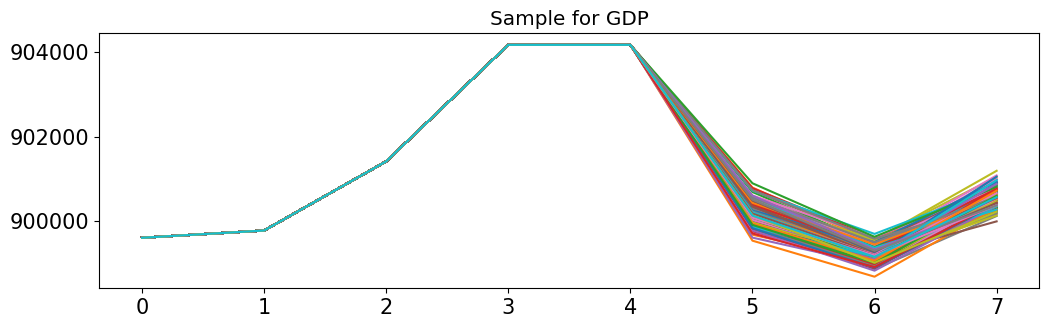

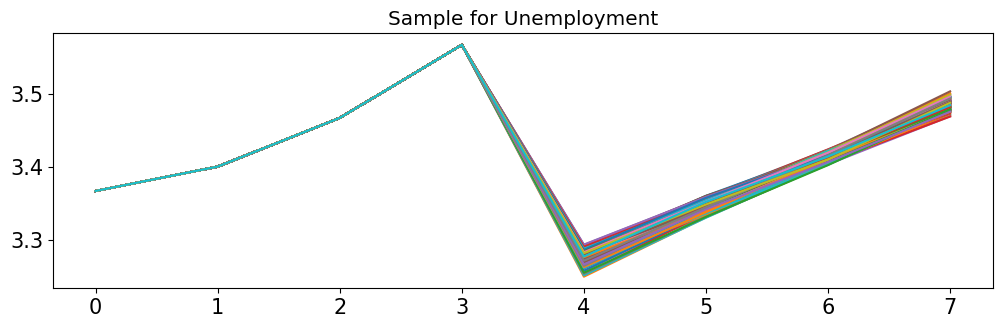

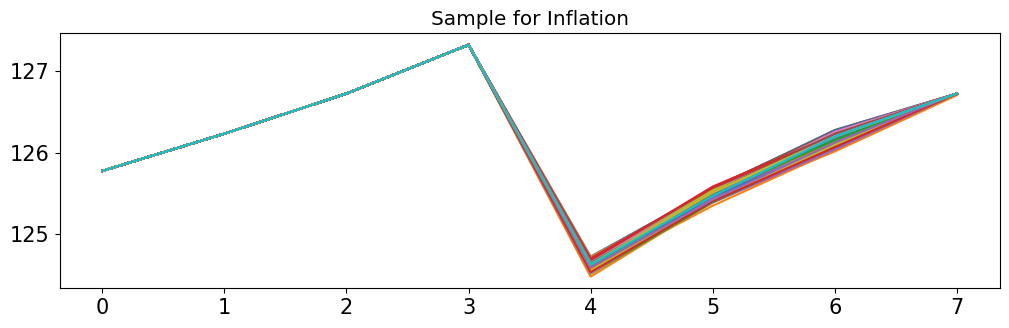

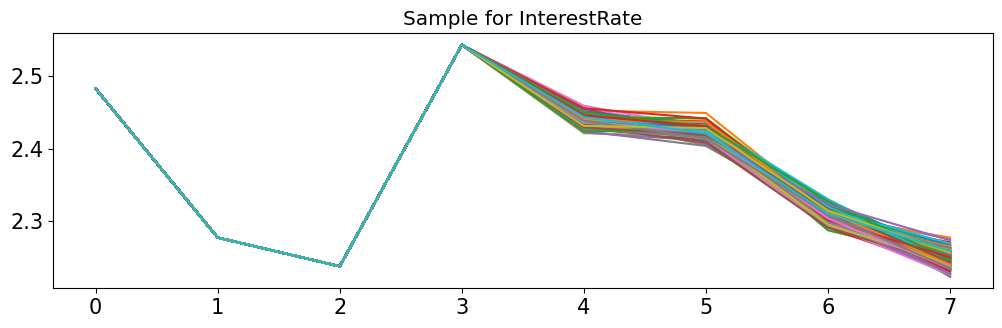

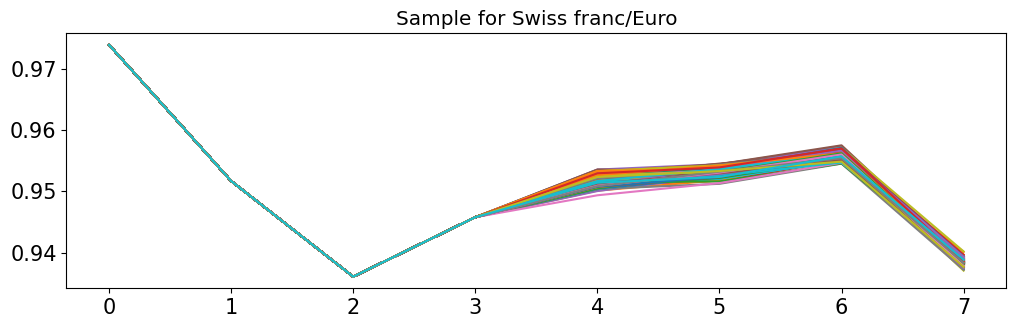

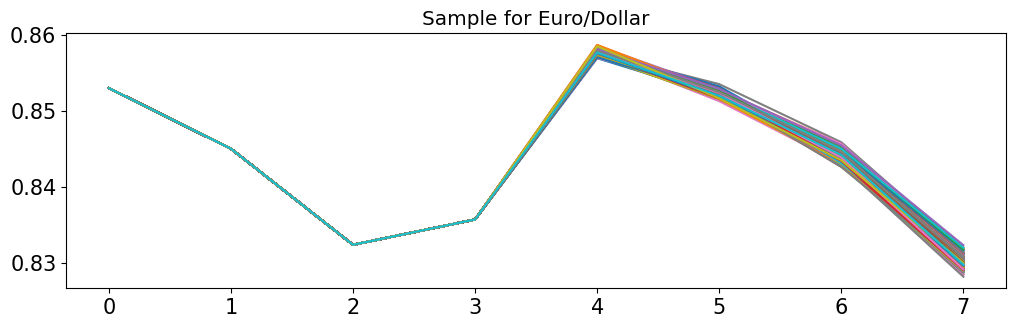

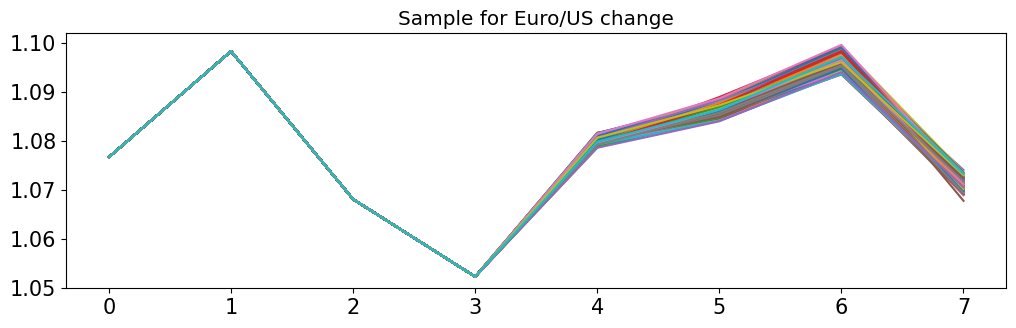

In [20]:
import matplotlib.pyplot as plt


feature_names = ['GDP', 'Unemployment', 'Inflation', 'InterestRate', 'Swiss franc/Euro', 'Euro/Dollar', 'Euro/US change']

plt.rcParams["font.size"] = 12

display_length = 8


for idx in range(feat_num):

    plt.figure(figsize=(10, 3))

    for i in range(sample.shape[0]):
        plt.plot(range(seq_length - display_length, seq_length), sample[i, -display_length:, idx], linestyle='solid', label=f'Sample {i+1}')

    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    #plt.legend()
    plt.title(f'Sample for {feature_names[idx]}')
    plt.show()